In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/g')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /g


In [0]:
BASEPATH = '/g/My Drive/Colab Notebooks/ieee-cis'

In [0]:
train_id = pd.read_csv(f'{BASEPATH}/data/train_identity.csv.zip')
train_trans = pd.read_csv(f'{BASEPATH}/data/train_transaction.csv.zip')

In [0]:
#@title
import abc
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import gc

def prediction_to_df(target_col, pred):
    if len(pred.shape) == 2:
        pred_cols = [f'{target_col}_{i}' for i in range(pred.shape[1])]
    else:
        pred_cols = [target_col]
    return pd.DataFrame(pred, columns=pred_cols)

class MLModel(abc.ABC):
    def __init__(self, name, path, label_col, target_col, num_folds=0, feat_cols=None, out_cols=None):
        self.model = None
        self.name = name
        self.path = path
        self.fold_model_path = None
        self.label_col = label_col
        self.target_col = target_col
        self.num_folds = num_folds
        self.feat_cols = feat_cols
        self.out_cols = out_cols
        print(f'features {self.feat_cols}')

    @abc.abstractclassmethod
    def load(self, model_path):
        assert False

    @abc.abstractclassmethod
    def save(self, model_path):
        assert False

    def pre_fold(self, fold):
        model_name = f'{self.name}-{fold}'
        self.fold_model_path = f'{self.path}/models/{model_name}'
        try:
            self.load(self.fold_model_path)
            print(f'loaded model from {self.fold_model_path}')
        except:
            pass

    def post_fold(self, fold):
        self.save(self.fold_model_path)

    @abc.abstractclassmethod
    def train_one_fold(self, fold, params, train_df, train_idx, valid_idx):
        assert False

    @abc.abstractclassmethod
    def predict_one_fold(self, df):
        assert False

    def pre_train(self):
        return

    def post_train(self):
        return

    def train(self, train_df, params, stratified=False, random_shuffle=True):
        print("Starting training. Train shape: {}".format(train_df.shape))

        # Cross validation model
        if self.num_folds > 1:
            if stratified:
                kf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=326)
            else:
                kf = KFold(n_splits=self.num_folds, shuffle=True, random_state=326)
        else:
            kf = MLSplit(random_shuffle, 0.8)

        self.pre_train()
        # k-fold
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df[self.feat_cols], train_df[self.target_col])):
            print("Fold {}".format(fold + 1))

            self.pre_fold(fold)
            self.train_one_fold(fold, params, train_df, train_idx, valid_idx)
            self.post_fold(fold)
            gc.collect()

        self.post_train()

    def predict(self, df):
        include_header = False
        pred_file = f'{self.path}/{self.name}_pred.csv'
        try:
            last_pred_time = pd.read_csv(pred_file).iloc[-1].timestamp
            df = df[df.timestamp > last_pred_time].copy()
            if len(df) == 0:
                return
        except:
            include_header = True

        sub_preds = None
        for fold in range(self.num_folds):
            self.pre_fold(fold)
            pred = self.predict_one_fold(df[self.feat_cols]) / self.num_folds
            if sub_preds is None:
                sub_preds = np.zeros(pred.shape)
            sub_preds += pred

        pred_df = prediction_to_df(self.target_col, sub_preds)
        df = pd.concat([df.reset_index(drop=True), pred_df], axis=1)

        if self.out_cols is None:
            self.out_cols = [self.label_col] + pred_df.columns.tolist()

        if include_header:
            df[self.out_cols].to_csv(pred_file, index=False)
        else:
            out_csv = df[self.out_cols].to_csv(index=False, header=include_header)
            f = open(pred_file, 'a')
            f.write(out_csv)

class LGBModel(MLModel):
    def __init__(self, name, path, label_col, target_col, num_folds=0, feat_cols=None, out_cols=None):
        super().__init__(name, path, label_col, target_col, num_folds, feat_cols, out_cols)
        self.feature_importance_df = pd.DataFrame()

    def load(self, model_path):
        self.model = lgb.Booster(model_file=model_path)

    def save(self, model_path):
        self.model.save_model(filename=model_path, num_iteration=self.model.best_iteration)
        print(f'saved model iteration {self.model.best_iteration} to {model_path}')

    def train_one_fold(self, fold, params, train_df, train_idx, valid_idx):
        params['seed'] = params['bagging_seed'] = params['drop_seed'] = int(2 ** fold)
        train_set = lgb.Dataset(train_df[self.feat_cols].iloc[train_idx],
                                label=train_df[self.target_col].iloc[train_idx])
        valid_set = lgb.Dataset(train_df[self.feat_cols].iloc[valid_idx],
                                label=train_df[self.target_col].iloc[valid_idx])

        self.model = lgb.train(params, train_set, valid_sets=valid_set, verbose_eval=100)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = self.feat_cols
        fold_importance_df["importance"] = np.log1p(
            self.model.feature_importance(importance_type='gain', iteration=self.model.best_iteration))
        fold_importance_df["fold"] = fold + 1
        self.feature_importance_df = pd.concat([self.feature_importance_df, fold_importance_df], axis=0)

    def predict_one_fold(self, df):
        return self.model.predict(df[self.feat_cols], num_iteration=self.model.best_iteration)

    def post_train(self):
        super().post_train()
        display_importances(self.feature_importance_df)


In [0]:
import seaborn as sns
# Display/plot feature importance
def display_importances(feature_importance_df_):
    sorted_df = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    print(sorted_df)

    threshold = 40
    cols = sorted_df[:threshold].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances.png')



In [0]:
# change all object type columns to int columns and mark them as categorical
def object_to_cat(df):
  for c in df.columns:
      col_type = df[c].dtype
      if col_type == object or col_type.name == 'category':
          print(f'Converting {c} to category')
          df[c] = df[c].astype('category')

In [7]:
object_to_cat(train_trans)

Converting ProductCD to category
Converting card4 to category
Converting card6 to category
Converting P_emaildomain to category
Converting R_emaildomain to category
Converting M1 to category
Converting M2 to category
Converting M3 to category
Converting M4 to category
Converting M5 to category
Converting M6 to category
Converting M7 to category
Converting M8 to category
Converting M9 to category


In [0]:
import os
lgb_params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'verbose': 1,

    'num_rounds': 10000,
    #'is_unbalance': True,
    #'scale_pos_weight': 8.951238929246692,
    'early_stopping': 300,

    'bagging_freq': 3,
    'bagging_fraction': 0.33,
    'bagging_seed': 11,
    'boost_from_average': 'false',
    'feature_fraction': 0.5,
    'max_depth': -1,
    'min_data_in_leaf': 80,
    # 'min_sum_hessian_in_leaf': 5.0,
    'num_leaves': 27,
    'num_threads': os.cpu_count(),
    'tree_learner': 'serial',
}

exclude_cols = {'TransactionID', 'isFraud'}
feat_cols = [col for col in train_trans.columns if col not in exclude_cols]

In [17]:
lgb_params

{'bagging_fraction': 0.9,
 'bagging_freq': 3,
 'bagging_seed': 11,
 'boost_from_average': 'false',
 'boosting': 'gbdt',
 'early_stopping': 200,
 'feature_fraction': 0.7,
 'learning_rate': 0.03,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 80,
 'num_leaves': 255,
 'num_rounds': 5000,
 'num_threads': 2,
 'objective': 'binary',
 'tree_learner': 'serial',
 'verbose': 1}

features ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.911991
[200]	valid_0's auc: 0.949792
[300]	valid_0's auc: 0.962264
[400]	valid_0's auc: 0.967212
[500]	valid_0's auc: 0.969815
[600]	valid_0's auc: 0.971514
[700]	valid_0's auc: 0.972351
[800]	valid_0's auc: 0.973026
[900]	valid_0's auc: 0.973495
[1000]	valid_0's auc: 0.973993
[1100]	valid_0's auc: 0.974325
[1200]	valid_0's auc: 0.97446
[1300]	valid_0's auc: 0.974629
[1400]	valid_0's auc: 0.974679
[1500]	valid_0's auc: 0.974675
[1600]	valid_0's auc: 0.974664
Early stopping, best iteration is:
[1446]	valid_0's auc: 0.974768
saved model iteration 1446 to /g/My Drive/Colab Notebooks/ieee-cis/models/lgb_all_features-0
Fold 2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.912852
[200]	valid_0's auc: 0.947425
[300]	valid_0's auc: 0.961219
[400]	valid_0's auc: 0.965499
[500]	valid_0's auc: 0.967986
[600]	valid_0's auc: 0.969726
[700]	valid_0's auc: 0.970838
[800]	valid_

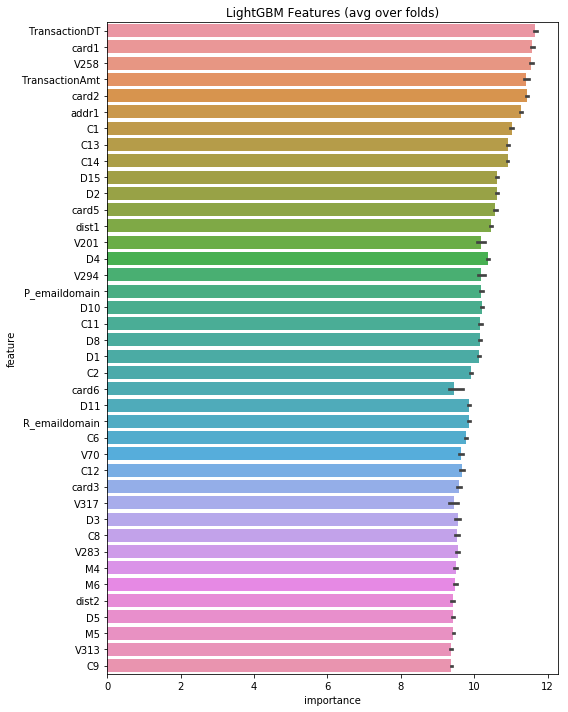

In [18]:
lgb_model = LGBModel(f'lgb_all_features', BASEPATH, 'TransactionID', 'isFraud', 
                     num_folds=5, feat_cols=feat_cols)
lgb_model.train(train_trans, lgb_params, stratified=False, random_shuffle=True)
